# Data Mining EIA/NSRDB Correlation Project

## Import necessary libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5pyd
from scipy.spatial import cKDTree
import scipy.stats as stats

### Extract EIA data: here we are using 860 data and 923 data

#### Start by reading in the data sets

In [3]:
# READ IN EIA 923 DATA
data923 = pd.read_excel("923_data_2020.xlsx")

# READ IN EIA 860 DATA
data860 = pd.read_excel("860_data_2020.xlsx")  

# READ IN 860 locational DATA
dataLatLon = pd.read_excel("860_locational_2020.xlsx")   

#### Clean the data

In [4]:
# CLEAN UP THE 923 DATA
clean_923 = data923[(data923['Reported\nPrime Mover'] == "PV")]

# Eliminate unnecessary columns
important_columns_923 = ['Plant Id', 'Plant Name', 'Plant State', 'Reported\nPrime Mover', 'Net Generation\n(Megawatthours)']
clean_923 = clean_923[important_columns_923]

In [5]:
# CLEAN UP THE 860 DATA
clean_860 = data860[(data860['Prime Mover'] == 'PV')] 

# Eliminate unnecessary columns
important_columns_860 = ['Plant Code','Nameplate Capacity (MW)'] 
clean_860 = clean_860[important_columns_860]

In [6]:
#CLEAN UP LOCATION DATA
important_columns_loc = ['Plant Code', 'Latitude', 'Longitude']
clean_LatLon = dataLatLon[important_columns_loc]

#### Combine datasets into one table

In [7]:
# Merge EIA 923 and 860 data
plant_df= pd.merge(clean_923, clean_860, left_on='Plant Id', right_on='Plant Code', how='inner')
# Merge locational data
plant_df= pd.merge(plant_df, clean_LatLon, left_on='Plant Code', right_on='Plant Code', how='inner')

In [8]:
# Clean up table columns
final_plant_df = plant_df.drop(columns=['Plant Code', 'Reported\nPrime Mover'])
final_plant_df = final_plant_df.rename(columns={'Net Generation\n(Megawatthours)': 'Net Generation (MWh)'})

#### Create capacity factor

In [9]:
# Add column for capacity factor
final_plant_df['capacity_factor'] = (final_plant_df['Net Generation (MWh)'] / 
                                     (final_plant_df['Nameplate Capacity (MW)'] * 8760))

#### Craete subset to analyze

In [14]:
# Filter data to include only plants with capacity > 20 MW
filtered_df = final_plant_df[final_plant_df['Nameplate Capacity (MW)'] > 20]

In [32]:
num_rows = filtered_df.shape[0]
print('Number of rows:', num_rows)

Number of rows: 445


## NSRDB Data

In [17]:
#Read NSRDB data and extract coordinates
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5", 'r')

# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


#### Find the nearest site it using a KDtree

In [18]:
# Prepare KDTree for nearest site lookup
dset_coords = f['coordinates'][...]
tree = cKDTree(dset_coords)

# Function to find the nearest NSRDB site for given lat/lon
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

In [19]:
# Extract GHI, DNI, and DHI datasets
dset_dni = f['dni']
dset_ghi = f['ghi']
dset_dhi = f['dhi']

# Add columns for DNI, GHI, DHI in the DataFrame
filtered_df['annual_dni'] = np.nan
filtered_df['annual_ghi'] = np.nan
filtered_df['annual_dhi'] = np.nan

/var/folders/kl/8nm_b54n7917k8b6071ds8500000gn/T/ipykernel_30606/2124287460.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['annual_dni'] = np.nan
/var/folders/kl/8nm_b54n7917k8b6071ds8500000gn/T/ipykernel_30606/2124287460.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['annual_ghi'] = np.nan
/var/folders/kl/8nm_b54n7917k8b6071ds8500000gn/T/ipykernel_30606/2124287460.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [20]:
# Loop through each plant and calculate the annual DNI, GHI, DHI
for index, row in filtered_df.iterrows():
    lat_coord, lon_coord = row['Latitude'], row['Longitude']
    print(f"Processing Plant: {row['Plant Name']} in {row['Plant State']}")
    
    nearest_idx = nearest_site(tree, lat_coord, lon_coord)
    
    # Extract time series for DNI, GHI, DHI
    tseries_dni = dset_dni[:, nearest_idx] / dset_dni.attrs['psm_scale_factor']
    tseries_ghi = dset_ghi[:, nearest_idx] / dset_ghi.attrs['psm_scale_factor']
    tseries_dhi = dset_dhi[:, nearest_idx] / dset_dhi.attrs['psm_scale_factor']
    
    # Create DataFrames for the timeseries data
    time_index = pd.date_range(start='2020-01-01', periods=len(tseries_dni), freq='H')
    df_dni = pd.DataFrame({'dni': tseries_dni}, index=time_index)
    df_ghi = pd.DataFrame({'ghi': tseries_ghi}, index=time_index)
    df_dhi = pd.DataFrame({'dhi': tseries_dhi}, index=time_index)
    
    # Aggregate the data to find annual values
    annual_dni = df_dni.groupby(df_dni.index.year)['dni'].mean().sum()
    annual_ghi = df_ghi.groupby(df_ghi.index.year)['ghi'].mean().sum()
    annual_dhi = df_dhi.groupby(df_dhi.index.year)['dhi'].mean().sum()
    
    # Assign the annual values to the DataFrame
    filtered_df.at[index, 'annual_dni'] = annual_dni
    filtered_df.at[index, 'annual_ghi'] = annual_ghi
    filtered_df.at[index, 'annual_dhi'] = annual_dhi


Processing Plant: Stillwater Facility in NV
Processing Plant: Imperial Valley Solar, LLC in CA
Processing Plant: Imperial Valley Solar, LLC in CA
Processing Plant: Imperial Valley Solar, LLC in CA
Processing Plant: DeSoto Next Generation Solar Energy in FL
Processing Plant: Solar Blythe LLC in CA
Processing Plant: Cimarron Solar Facility in NM
Processing Plant: Alpine Solar in CA
Processing Plant: San Luis Valley Solar Ranch in CO
Processing Plant: Roadrunner Solar in NM
Processing Plant: Panoche Valley Solar Farm in CA
Processing Plant: Cogentrix of Alamosa in CO
Processing Plant: Agua Caliente Solar Project in AZ
Processing Plant: Agua Caliente Solar Project in AZ
Processing Plant: Agua Caliente Solar Project in AZ
Processing Plant: AV Solar Ranch One in CA
Processing Plant: California Valley Solar Ranch in CA
Processing Plant: California Valley Solar Ranch in CA
Processing Plant: California Valley Solar Ranch in CA
Processing Plant: California Valley Solar Ranch in CA
Processing Pla

In [22]:
# Check the filtered DataFrame
print(filtered_df)

      Plant Id                           Plant Name Plant State  \
26       50765                  Stillwater Facility          NV   
87       56917           Imperial Valley Solar, LLC          CA   
88       56917           Imperial Valley Solar, LLC          CA   
89       56917           Imperial Valley Solar, LLC          CA   
92       56929  DeSoto Next Generation Solar Energy          FL   
...        ...                                  ...         ...   
4406     64103                Desert Harvest II LLC          CA   
4407     64104                Maverick Solar 4, LLC          CA   
4429     64158                 Mechanicsville Solar          VA   
4432     64169                Albemarle Beach Solar          NC   
4447     64211                               Baxley          GA   

      Net Generation (MWh)  Nameplate Capacity (MW)   Latitude   Longitude  \
26                37878.00                     22.0  39.547537 -118.555613   
87               413411.00             

## Correlation Analysis 

In [23]:
# Select the columns for correlation
corr_columns = ['Net Generation (MWh)', 'Nameplate Capacity (MW)', 'capacity_factor', 'annual_dni', 'annual_ghi', 'annual_dhi']


#### Calculate correlation matrix & p-values

In [30]:
# Initialize an empty DataFrame for p-values with the same columns and index as the correlation matrix
p_values = pd.DataFrame(np.zeros((len(corr_columns), len(corr_columns))), columns=corr_columns, index=corr_columns)

# Compute the correlation matrix
correlation_matrix = filtered_df[corr_columns].corr()

# Calculate p-values for each pair of variables
for col1 in corr_columns:
    for col2 in corr_columns:
        if col1 != col2:
            corr, p_value = stats.pearsonr(filtered_df[col1], filtered_df[col2])
            p_values.loc[col1, col2] = p_value
        else:
            p_values.loc[col1, col2] = np.nan  # Set p-value to NaN for the diagonal

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Set pandas to display float values in decimal format rather than scientific notation
pd.options.display.float_format = '{:.6f}'.format

# Display the p-value matrix in decimal format
print("P-value Matrix:")
print(p_values)

Correlation Matrix:
                         Net Generation (MWh)  Nameplate Capacity (MW)  \
Net Generation (MWh)                 1.000000                 0.114800   
Nameplate Capacity (MW)              0.114800                 1.000000   
capacity_factor                      0.766021                -0.349706   
annual_dni                           0.379666                -0.102714   
annual_ghi                           0.364651                -0.106207   
annual_dhi                          -0.215801                -0.075968   

                         capacity_factor  annual_dni  annual_ghi  annual_dhi  
Net Generation (MWh)            0.766021    0.379666    0.364651   -0.215801  
Nameplate Capacity (MW)        -0.349706   -0.102714   -0.106207   -0.075968  
capacity_factor                 1.000000    0.367018    0.362236   -0.162487  
annual_dni                      0.367018    1.000000    0.954151   -0.291538  
annual_ghi                      0.362236    0.954151    1.000000  

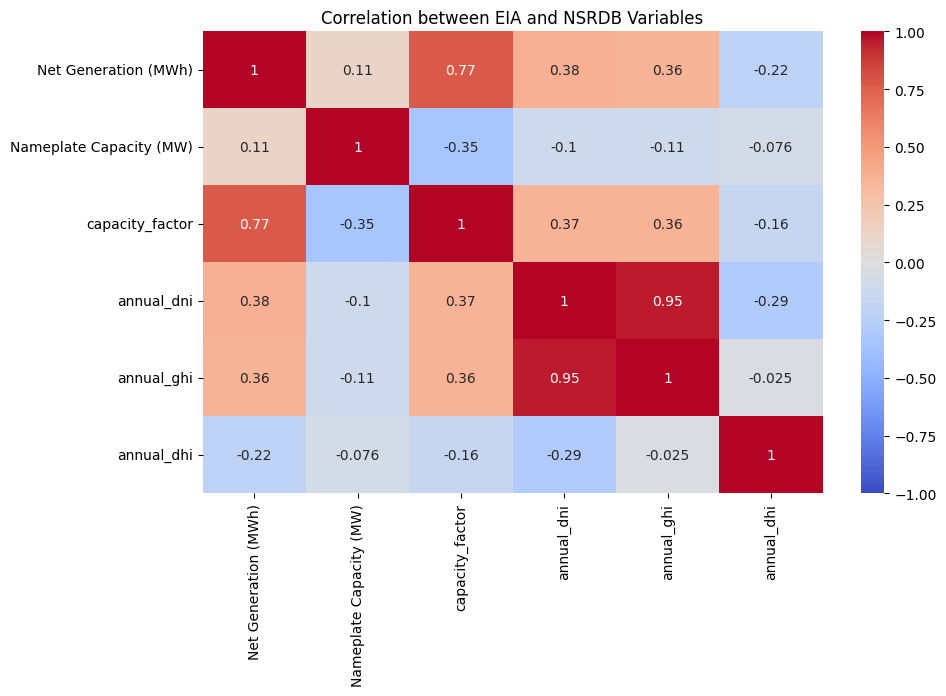

In [25]:
# Visualize the correlation matrix with a heatmap
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between EIA and NSRDB Variables')
plt.show()